In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import gzip
nltk.download('punkt')
nltk.download('stopwords')
import string
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam



#download(stopwords)

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
sms = pd.read_csv("/content/gdrive/MyDrive/Materiale Text Mining/spam.csv", encoding='latin-1')
sms.dropna(how="any", inplace=True, axis=1)
sms.columns = ['label', 'message']

sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
label_counts = sms['label'].value_counts()
label_percentages = sms['label'].value_counts(normalize=True) * 100
print(label_counts, label_percentages)

ham     4825
spam     747
Name: label, dtype: int64 ham     86.593683
spam    13.406317
Name: label, dtype: float64


In [6]:
sms['char_len'] = sms.message.apply(len)
sms['word_len'] = sms['message'].apply(lambda x: len(x.split(' ')))

In [7]:
# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text) #Removes square brackets and their contents.
    text = re.sub('https?://\S+|www\.\S+', '', text) # Removes URLs
    text = re.sub('<.*?>+', '', text) #Removes HTML tags
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #Removes punctuation
    text = re.sub('\n', '', text) #Removes newline characters
    text = re.sub('\w*\d\w*', '', text) #Removes words containing digits
    return text

In [8]:
sms['message_clean'] = sms['message'].apply(clean_text)
sms.head()

,label,message,char_len,word_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,29,6,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,49,11,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,nah i dont think he goes to usf he lives aroun...


In [9]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c', 'ur', 'dont', 'doin', 'ure' ]
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

sms['message_clean'] = sms['message_clean'].apply(remove_stopwords)
sms.head()

,label,message,char_len,word_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,29,6,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,free entry wkly comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,49,11,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,nah think goes usf lives around though


In [10]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [11]:
sms['message_clean'] = sms['message_clean'].apply(stemm_text)
sms.head()

,label,message,char_len,word_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,29,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,49,11,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,nah think goe usf live around though


In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(sms['label'])

sms['target_encoded'] = le.transform(sms['label'])
sms.head()

,label,message,char_len,word_len,message_clean,target_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,go jurong point crazi avail bugi n great world...,0
1,ham,Ok lar... Joking wif u oni...,29,6,ok lar joke wif oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,free entri wkli comp win fa cup final tkts m...,1
3,ham,U dun say so early hor... U c already then say...,49,11,dun say earli hor alreadi say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,nah think goe usf live around though,0


In [13]:
x = sms['message_clean']
y = sms['target_encoded']

print(len(x), len(y))

5572 5572


In [14]:
pip install transformers


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from tqdm import tqdm
import torch

In [16]:
sms = sms[['message_clean', 'target_encoded']]


In [17]:
# Split data into train and test sets
train_data, test_data = train_test_split(sms, test_size=0.25, random_state=42)

In [18]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # Assuming binary classification

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# Tokenize and convert data to PyTorch tensors
def tokenize_data(data, tokenizer, max_len=128):
    input_ids = []
    attention_masks = []

    for message in data['message_clean']:
        encoded_message = tokenizer.encode_plus(
            message,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        input_ids.append(encoded_message['input_ids'])
        attention_masks.append(encoded_message['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(data['target_encoded'].values)

    return input_ids, attention_masks, labels

train_input_ids, train_attention_masks, train_labels = tokenize_data(train_data, tokenizer)
test_input_ids, test_attention_masks, test_labels = tokenize_data(test_data, tokenizer)

In [20]:
# Create DataLoader
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

batch_size = 10
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [22]:
# Define optimizer and loss function
optimizer = Adam(model.parameters(), lr=2e-5)
criterion = CrossEntropyLoss()

In [23]:
# Training loop
epochs = 5

train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs} - Training'):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        predictions = torch.argmax(outputs.logits, dim=1)
        total_correct += torch.sum(predictions == labels).item()
        total_samples += labels.size(0)

    average_loss = total_loss / len(train_dataloader)
    training_accuracy = total_correct / total_samples
    train_losses.append(average_loss)
    train_accuracies.append(training_accuracy)
    print(f'Epoch {epoch + 1}/{epochs} - Training Loss: {average_loss:.4f}, Training Accuracy: {training_accuracy * 100:.2f}%')


Epoch 1/5 - Training: 100%|██████████| 418/418 [01:33<00:00,  4.46it/s]


Epoch 1/5 - Training Loss: 0.1422, Training Accuracy: 95.19%


Epoch 2/5 - Training: 100%|██████████| 418/418 [01:33<00:00,  4.46it/s]


Epoch 2/5 - Training Loss: 0.0450, Training Accuracy: 98.68%


Epoch 3/5 - Training: 100%|██████████| 418/418 [01:33<00:00,  4.48it/s]


Epoch 3/5 - Training Loss: 0.0178, Training Accuracy: 99.62%


Epoch 4/5 - Training: 100%|██████████| 418/418 [01:32<00:00,  4.51it/s]


Epoch 4/5 - Training Loss: 0.0107, Training Accuracy: 99.76%


Epoch 5/5 - Training: 100%|██████████| 418/418 [01:32<00:00,  4.52it/s]

Epoch 5/5 - Training Loss: 0.0074, Training Accuracy: 99.86%


In [24]:
# Validation
model.eval()
total_correct_val = 0
total_samples_val = 0

with torch.no_grad():
  for batch in tqdm(test_dataloader, desc=f'Epoch {epoch + 1}/{epochs} - Validation'):
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

    outputs = model(input_ids, attention_mask=attention_mask)
    predictions = torch.argmax(outputs.logits, dim=1)
    total_correct_val += torch.sum(predictions == labels).item()
    total_samples_val += labels.size(0)

validation_accuracy = total_correct_val / total_samples_val
val_accuracies.append(validation_accuracy)
print(f'Epoch {epoch + 1}/{epochs} - Validation Accuracy: {validation_accuracy * 100:.2f}%')


Epoch 5/5 - Validation: 100%|██████████| 140/140 [00:09<00:00, 14.08it/s]

Epoch 5/5 - Validation Accuracy: 98.06%


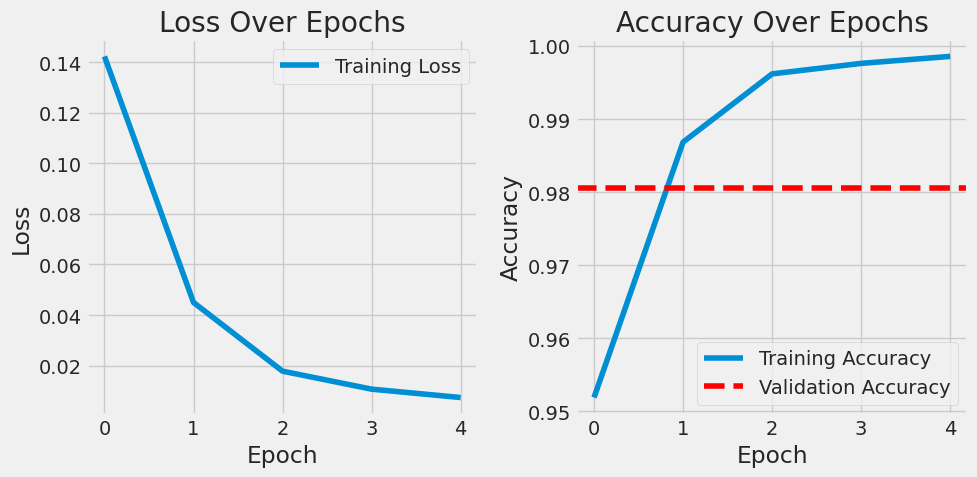

<Figure size 640x480 with 0 Axes>

In [28]:
import matplotlib.ticker as ticker

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
#plt.plot(val_accuracies, label='Validation Accuracy')
plt.axhline(y=val_accuracies[0], color='r', linestyle='--', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Remove decimals from x-axis ticks
for ax in plt.gcf().axes:
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: int(x)))

plt.tight_layout()
plt.show()

In [26]:
val_accuracies


[0.9806173725771715]

Generating Predictions - Testing: 100%|██████████| 140/140 [00:09<00:00, 14.25it/s]


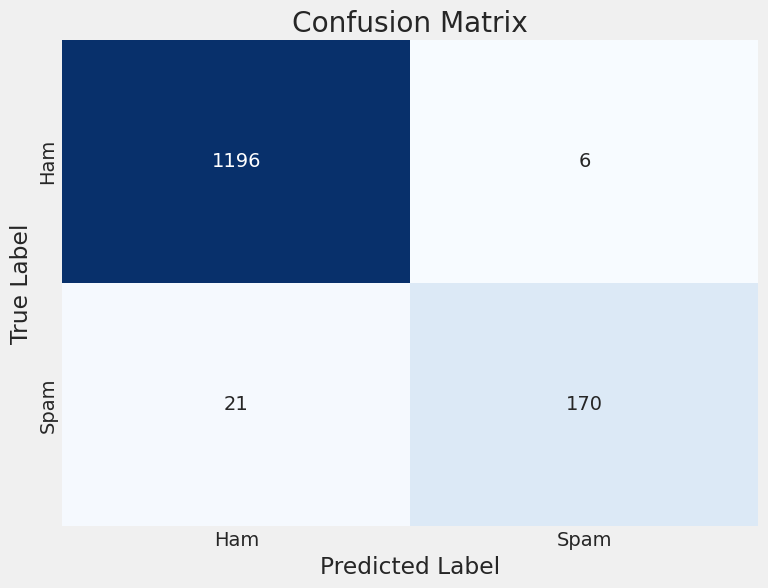

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluation on Test Set
model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc='Generating Predictions - Testing'):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [36]:
precision = precision_score(true_labels, predicted_labels, pos_label=1)
recall = recall_score(true_labels, predicted_labels, pos_label=1)
f1 = f1_score(true_labels, predicted_labels, pos_label=1)
precision, recall, f1

(0.9659090909090909, 0.8900523560209425, 0.9264305177111717)

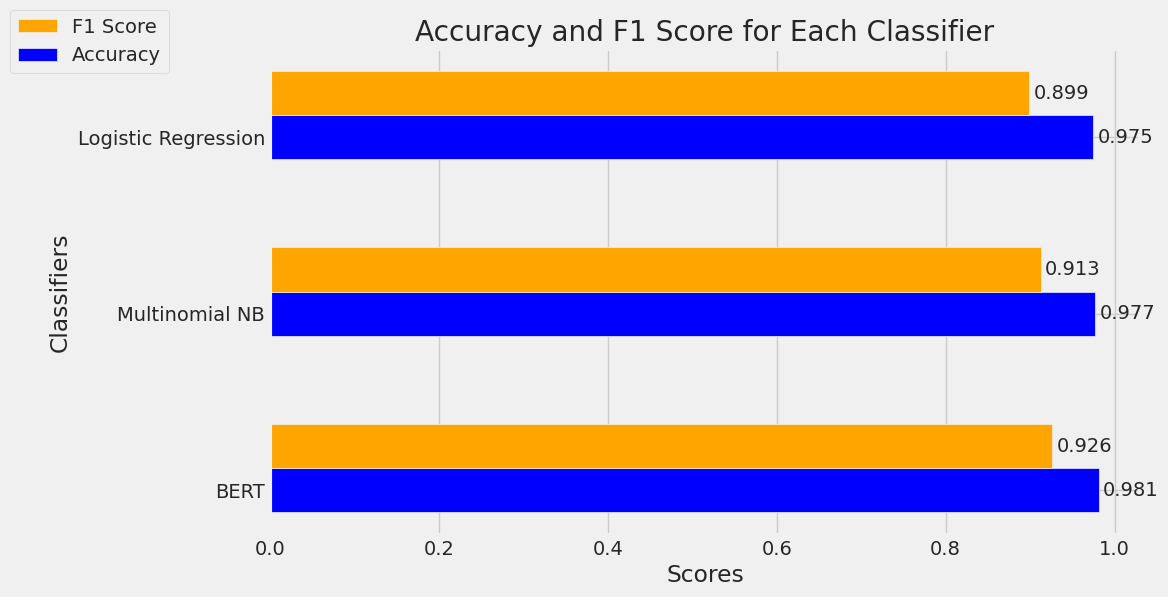

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Classifier names
classifiers = ['BERT', 'Multinomial NB', 'Logistic Regression']

# Provided accuracy and F1 score values
accuracy_values = [0.981, 0.977, 0.975]
f1_values = [0.9264, 0.9126, 0.899]

# Bar width
bar_width = 0.25

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting accuracy bars
bars_accuracy = ax.barh(classifiers, accuracy_values, bar_width, label='Accuracy', color='blue')

# Plotting F1 score bars next to accuracy bars
bars_f1 = ax.barh(np.arange(len(classifiers)) + bar_width, f1_values, bar_width, label='F1 Score', color='orange')

# Adding labels and title
ax.set_ylabel('Classifiers')
ax.set_xlabel('Scores')
ax.set_title('Accuracy and F1 Score for Each Classifier')
ax.legend()

# Display values on the right of the bars
for bars in [bars_accuracy, bars_f1]:
    for bar in bars:
        width = bar.get_width()
        ax.annotate(f'{width:.3f}', xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(3, 0),  # 3 points horizontal offset
                    textcoords="offset points",
                    ha='left', va='center')

# Place the legend in the top-left corner
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='upper left', bbox_to_anchor=(-0.31, 1.1))

# Show the plot
plt.show()

